In [1]:
from random import seed
from typing import Optional, Type, Union

import gym
import numpy as np
import tensorflow as tf
import torch
import torch as th
from gym.wrappers import TimeLimit
from imitation.algorithms import bc
from imitation.algorithms.adversarial.gail import GAIL
from imitation.algorithms.adversarial.airl import AIRL

from imitation.data import rollout, types
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from RlBaselines3Zoo import enjoy
from sb3_contrib.tqc.policies import MultiInputPolicy
from sb3_contrib.tqc.tqc import TQC
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.on_policy_algorithm import OnPolicyAlgorithm
from stable_baselines3.common.policies import (ActorCriticPolicy, BaseModel,
                                               MultiInputActorCriticPolicy)
from stable_baselines3.common.torch_layers import (BaseFeaturesExtractor,
                                                   CombinedExtractor,
                                                   FlattenExtractor, NatureCNN,
                                                   create_mlp,
                                                   get_actor_critic_arch)
from stable_baselines3.common.type_aliases import GymEnv
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.ppo import MlpPolicy

from metaworld.envs import ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
from MetaWorld.metaworld.policies.sawyer_pick_place_v2_policy import \
    SawyerPickPlaceV2Policy
from MetaWorld.searchTest.utils import (LearnWrapper, MyEnv, ToyExpertModel,
                                        VecExtractor, benchmark_policy,
                                        parse_sampled_transitions,
                                        sample_expert_transitions,
                                        train_policy)
from MetaWorld.utilsMW.makeTrainingData import make_policy_dict
from MetaWorld.utilsMW.model_setup_obj import NetworkSetup
from MetaWorld.utilsMW.trainer import ActiveCritic, ActiveCriticArgs
from searchTest.utils import (MyEnv, ToyExpertModel, benchmark_policy,
                              get_num_bits, make_counter_embedding,
                              sample_expert_transitions, train_policy)
from utilsMW.dataLoaderMW import TorchDatasetMWToy
import os

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

policy_dict = make_policy_dict()
env_tag = 'pickplace'
gt_policy = policy_dict[env_tag]
pape = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]]()
pape._freeze_rand_vec = False
timelimit = TimeLimit(env=pape, max_episode_steps=100)
dv1 = DummyVecEnv([lambda: RolloutInfoWrapper(timelimit)])


class ImitationLearningWrapper:
    def __init__(self, policy, env: GymEnv):
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.policy = policy

    def predict(self, obsv, deterministic=None):
        actions = []
        for obs in obsv:
            actions.append(self.policy.get_action(obs))
        return actions


IGTP = ImitationLearningWrapper(policy=gt_policy[0], env=dv1).predict


def new_epoch(current_obs, check_obsvs):
    result = not th.equal(current_obs.reshape(-1)
                          [36:39], check_obsvs.reshape(-1)[36:39])
    return result


class DummyExtractor:
    def __init__(self):
        pass

    def forward(self, features):
        if type(features) is np.ndarray:
            features = th.tensor(features, dtype=th.float32)
        return features


def sample_expert_transitions_(expert):
    print("Sampling expert transitions.")
    rollouts = rollout.rollout(
        expert,
        dv1,
        rollout.make_sample_until(min_timesteps=None, min_episodes=10),
        unwrap=True,
        exclude_infos=False,
    )
    return rollout.flatten_trajectories(rollouts)


def new_epoch(current_obs, check_obsvs):
    result = not th.equal(current_obs.reshape(-1)
                          [36:39], check_obsvs.reshape(-1)[36:39])
    return result


class DummyExtractor:
    def __init__(self):
        pass

    def forward(self, features):
        if type(features) is np.ndarray:
            features = th.tensor(features)
        return features

from itertools import count
from select import epoll


class NoObsvSparseReward(gym.Env):
    def __init__(self, env:gym.Env, seq_len, device = 'cuda', seed=None) -> None:
        super().__init__()
        if seed is None:
            env = env()
            env._freeze_rand_vec = False
            self.env = TimeLimit(env=env, max_episode_steps=seq_len)
            self.env._freeze_rand_vec = False

        self.action_space = self.env.action_space
        self.bits = get_num_bits(self.env._max_episode_steps+1)
        lows = self.env.observation_space.low
        lows = np.append(lows, np.zeros(self.bits))
        highs = self.env.observation_space.high
        highs = np.append(highs, np.ones(self.bits))
        self.observation_space = gym.spaces.Box(low=lows, high=highs, dtype=self.env.observation_space.dtype)
        self.device = device

    def reset(self):
        response = self.env.reset()
        self.response = response
        step = make_counter_embedding(torch.tensor(self.env._elapsed_steps), self.bits)
        response = np.append(response, step)

        return response

    def step(self, action):
        obs, rew, done, info = self.env.step(action=action)
        info['obs'] = obs
        step = make_counter_embedding(torch.tensor(self.env._elapsed_steps), self.bits)
        obs = np.append(self.response, step)
        if done:
            rew = info['success']
        else:
            rew = 0

        return obs, rew, done, info

def strip_transitions(transitions:types.Transitions):
    observations = np.array(transitions.obs)
    striped_observations = strip_obs(observations, transitions)
    next_observations = np.array(transitions.obs)
    next_striped_observations = strip_obs(next_observations, transitions,  offset=1)
    new_dict = {
        'obs':striped_observations,
        'next_obs':next_striped_observations,
        'dones':transitions.dones,
        'infos':transitions.infos,
        'acts':transitions.acts
    }
    return types.Transitions(**new_dict)


def strip_obs(obs, transitions, offset = 0):
    dones = np.where(transitions.dones)[0]
    if len(dones) > 1:
        epch_len = dones[1] - dones[0]
    else:
        epch_len = len(obs)
    start_points = dones - epch_len + 1
    proto_obs = obs[start_points]
    proto_obs = np.expand_dims(proto_obs, axis=0)

    num_bits = get_num_bits(epch_len+1)
    counter_embedding = make_counter_embedding(torch.arange(offset, epch_len+offset), num_bits)
    counter_embedding = np.expand_dims(counter_embedding, axis=0)
    counter_embedding = np.repeat(counter_embedding, np.sum(transitions.dones, dtype=np.int32), axis=0)
    counter_embedding = counter_embedding.reshape(-1, counter_embedding.shape[-1])
    proto_obs = np.repeat(proto_obs, epch_len, axis=0)
    proto_obs = proto_obs.transpose([1,0,2])
    proto_obs = proto_obs.reshape(-1,proto_obs.shape[-1])
    proto_obs = np.concatenate((proto_obs, counter_embedding), axis=1)
    return proto_obs
path = '/home/hendrik/transitions/'
try:
    transitions = torch.load(path+'transitions')
except:
    os.makedirs(path)
    transitions = sample_expert_transitions(IGTP)
    torch.save(transitions, path+'transitions')

#stripped_transitions = strip_transitions(transitions)

2022-09-08 15:04:26.370724: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/hendrik/anaconda3/envs/tfTest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hendrik/anaconda3/envs/tfTest/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(
2022-09-08 15:04:29.654002: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-08 15:04:29.654097: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-08 15:04:29.654220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative 

1 Physical GPUs, 1 Logical GPUs


In [ ]:
transitions_10 = sample_expert_transitions_(IGTP)

In [3]:
learner = PPO("MlpPolicy", dv1, learning_rate=1e-6, n_epochs=1 , policy_kwargs=dict(net_arch = [dict(pi=[512, 512, 512], vf=[512, 512, 512])]))

In [4]:
bc_trainer = bc.BC(
    observation_space=dv1.observation_space,
    action_space=dv1.action_space,
    policy=learner.policy,
    demonstrations=transitions
)

In [ ]:
bc_trainer.train(n_epochs = 1)

In [ ]:
benchmark_policy(
    policy=learner.policy,
    path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/bc 2000 pap observable',
    logname='bc pap observable 2000',
    eval_epochs=100,
    val_env=dv1,
    stepid=0,
    best_reward=0,
    save_model=True,
    new_epoch=new_epoch,
    extractor=DummyExtractor())

In [ ]:
for i in range(1000):
    benchmark_policy(
        policy=learner.policy,
        path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/bc 2000 pap observable',
        logname='bc pap observable 2000',
        eval_epochs=100,
        val_env=dv1,
        stepid=i,
        best_reward=0,
        save_model=True,
        new_epoch=new_epoch,
        extractor=DummyExtractor())
    bc_trainer.train(n_epochs=1)

In [ ]:
ppo_policy_1 = learner.policy.state_dict()
torch.save(learner.policy.state_dict(), '/tmp/ppo1')

In [ ]:
learner = PPO("MlpPolicy", dv1, learning_rate=1e-6, n_epochs=1 , policy_kwargs=dict(net_arch = [dict(pi=[512, 512, 512], vf=[512, 512, 512])]))

In [ ]:
learner.policy.load_state_dict(torch.load)

In [ ]:
for i in range(1000):
    benchmark_policy(
        policy=learner.policy,
        path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/h',
        logname='b',
        eval_epochs=100,
        val_env=dv1,
        stepid=10*i,
        best_reward=0,
        save_model=True,
        new_epoch=new_epoch,
        extractor=DummyExtractor())
    learner.learn(total_timesteps=10000)

In [ ]:
learner = SAC(
    env=dv1,
    policy='MlpPolicy',
    learning_rate=1e-3,
    verbose=-1,
    policy_kwargs=dict(net_arch=[512,512,512]),
    ent_coef='auto_0.1'
)


reward_net = BasicRewardNet(
    dv1.observation_space, dv1.action_space, normalize_input_layer=RunningNorm,hid_sizes=[512,512,512]
)

In [ ]:
from sb3_contrib import TQC

policy_kwargs = dict(n_critics=2, n_quantiles=25)
learner = TQC("MlpPolicy", dv1, top_quantiles_to_drop_per_net=2, verbose=0, policy_kwargs=policy_kwargs)


reward_net = BasicRewardNet(
    dv1.observation_space, dv1.action_space, normalize_input_layer=RunningNorm,hid_sizes=[512,512,512]
)

In [ ]:
gail_trainer = GAIL(
    demonstrations=transitions,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=dv1,
    gen_algo=learner,
    reward_net=reward_net,
)

In [ ]:
airl_trainer = AIRL(
    demonstrations=transitions,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=2048,
    n_disc_updates_per_round=4,
    venv=dv1,
    gen_algo=learner,
    reward_net=reward_net,
)

In [ ]:
for i in range(1000):
    benchmark_policy(
        policy=learner.policy,
        path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/airl',
        logname='airl 2000',
        eval_epochs=100,
        val_env=dv1,
        stepid=i,
        best_reward=0,
        save_model=True,
        new_epoch=new_epoch,
        extractor=DummyExtractor())
    gail_trainer.train(total_timesteps=2000)

In [5]:
from metaworld.envs import ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE
from MetaWorld.utilsMW.makeTrainingData import make_policy_dict
policy_dict = make_policy_dict()
env_tag = 'pickplace'
pape = ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]]
from gym.wrappers import TimeLimit


In [ ]:
from imitation.algorithms.adversarial.airl import AIRL

In [ ]:
bc_trainer = bc.BC(
    observation_space=dv1.observation_space,
    action_space=dv1.action_space,
    demonstrations=stripped_transitions,
    policy=model.policy
)

In [ ]:
from stable_baselines3.common.base_class import BaseAlgorithm, BasePolicy
from imitation.rewards.reward_nets import RewardNet
rn = RewardNet(dv1.observation_space, dv1.action_space)

In [ ]:
AIRL(demonstrations=stripped_transitions, demo_batch_size=32, venv=dv1, gen_algo=best_policy, reward_net=)

In [2]:
stripped_transitions = strip_transitions(transitions)

In [3]:
nosr = NoObsvSparseReward(env=ALL_V2_ENVIRONMENTS_GOAL_OBSERVABLE[policy_dict[env_tag][1]], seq_len=100)

/home/hendrik/anaconda3/envs/tfTest/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [4]:
dnosr = DummyVecEnv([lambda: RolloutInfoWrapper(nosr)])

In [14]:
from typing import List, Callable

In [ ]:
class ResetWrapper(DummyVecEnv):
    def __init__(self, env_fns: List[Callable[[], gym.Env]]):
        super().__init__(env_fns)

    def reset(self) -> VecEnvObs:
        print('reset!')
        return super().reset()

In [ ]:
best_policy = ActorCriticPolicy(observation_space=dv1.observation_space, action_space=dv1.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [dict(pi=[512, 512, 512], vf=[512, 512, 512])])
best_policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation bc pickplace 10/BC trainer pickplace 10/best_modeltensor(0.0900)'))

In [5]:
learner = PPO("MlpPolicy", dnosr, learning_rate=1e-6, n_epochs=1 , policy_kwargs=dict(net_arch = [dict(pi=[1200, 1200, 1200], vf=[1200, 1200, 1200])], optimizer_class=torch.optim.AdamW))

In [12]:
learner.policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/non observable/best_modeltensor(0.5000)'))

<All keys matched successfully>

log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.44999998807907104
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.4699999988079071
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.46000000834465027
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.5299999713897705
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampl

/home/hendrik/Documents/master_project/Code/LanguagePolicies/utils/graphsTorch.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(3,3)


in trainer reward: 0.46000000834465027
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.4699999988079071
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.44999998807907104
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.5699999928474426
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.5
torch.Size([100, 100, 4])
log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo

KeyboardInterrupt: 

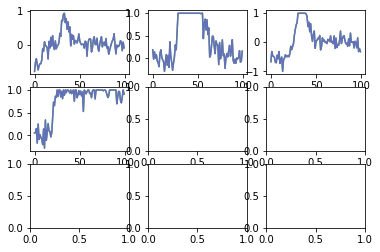

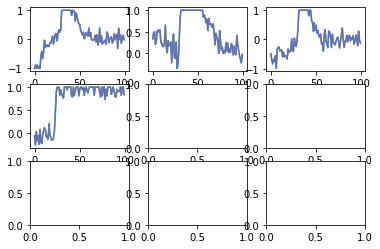

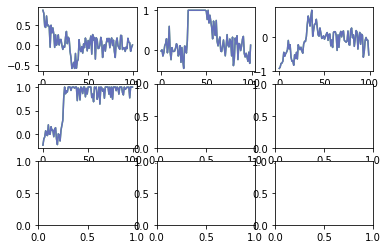

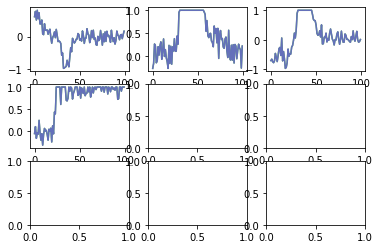

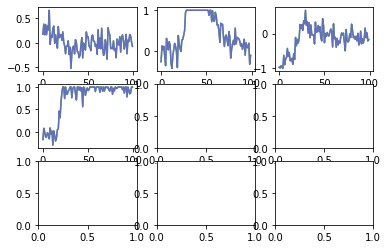

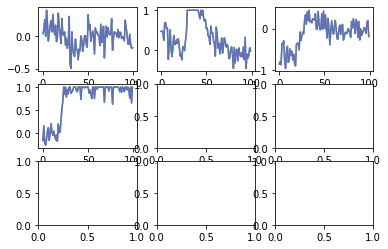

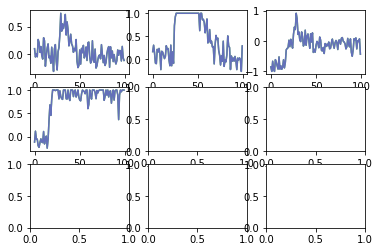

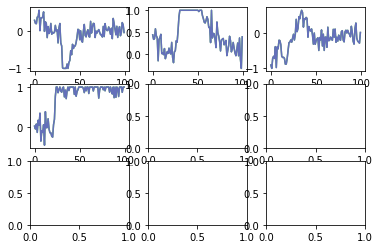

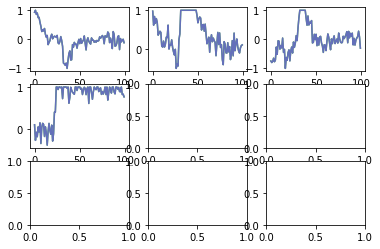

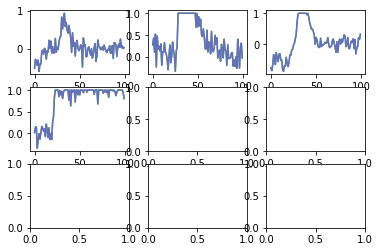

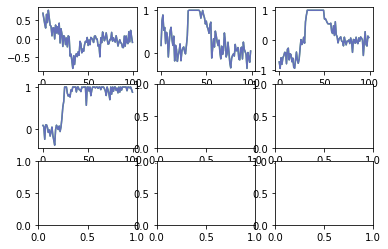

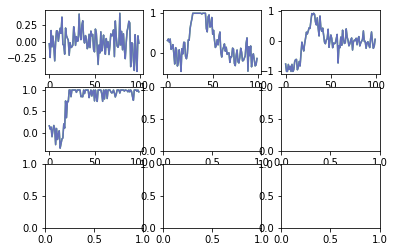

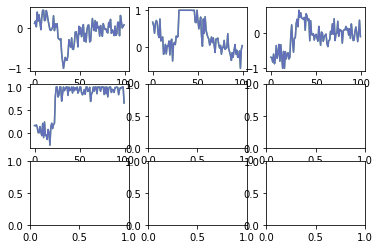

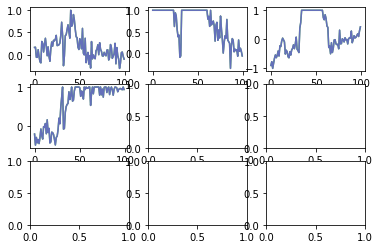

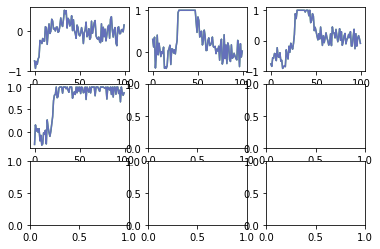

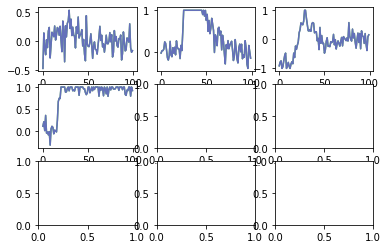

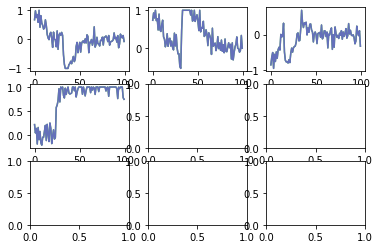

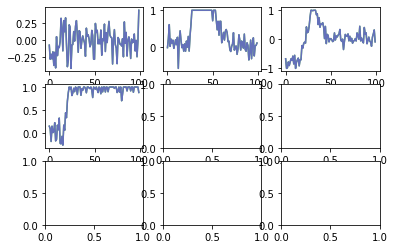

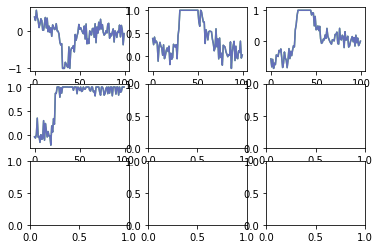

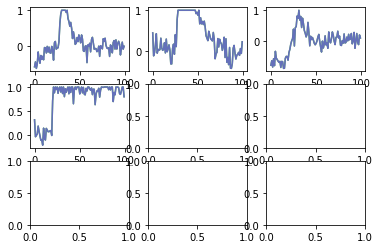

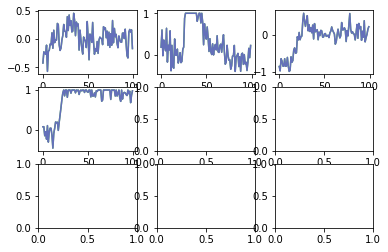

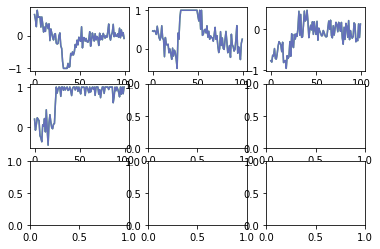

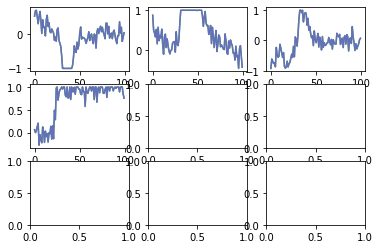

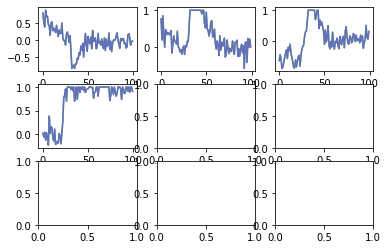

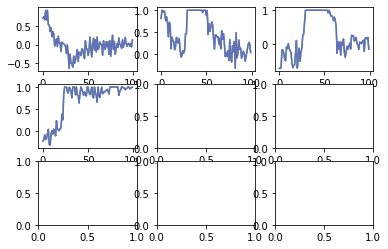

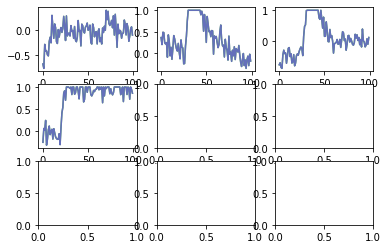

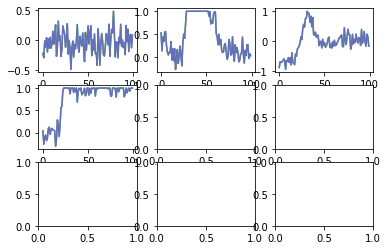

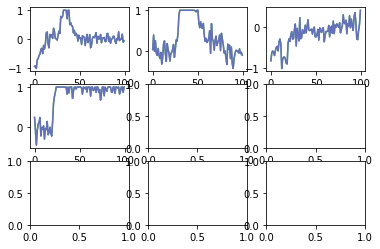

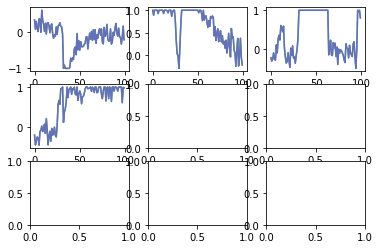

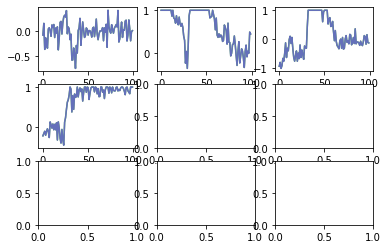

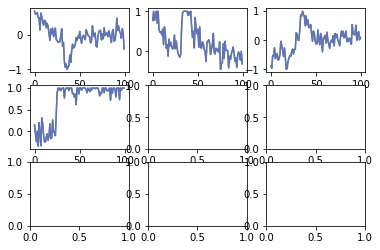

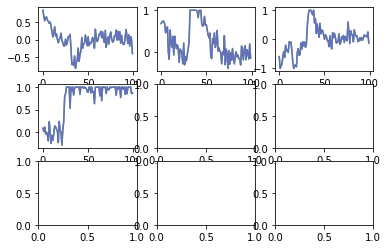

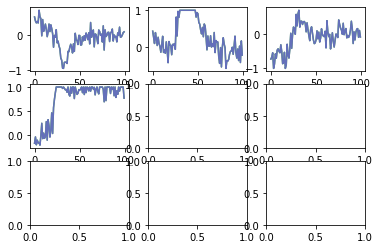

In [13]:
for i in range(1000):
    benchmark_policy(
    policy=learner.policy,
    path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo pickplace 0.5/',
    logname='non observable',
    eval_epochs=100,
    val_env=dnosr,
    stepid=10*i,
    best_reward=0,
    save_model=True,
    new_epoch=new_epoch,
    extractor=DummyExtractor())
    learner.learn(total_timesteps=1000)
    learner.lean()

In [10]:
pytorch_total_params = sum(p.numel() for p in learner.policy.parameters() if p.requires_grad)

In [11]:
pytorch_total_params

5883609

In [19]:
bc_trainer_nosr = bc.BC(
    observation_space=dnosr.observation_space,
    action_space=dnosr.action_space,
    policy=learner.policy,
    demonstrations=stripped_transitions,
    optimizer_cls=torch.optim.AdamW,
    optimizer_kwargs=dict(lr=1e-5)
)

log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:32, 189.79batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:32, 192.54batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:33, 189.33batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:33, 189.31batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:32, 192.56batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:32, 192.47batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.0
torch.Size([100, 100, 4])


6250batch [00:33, 188.53batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.009999999776482582
torch.Size([100, 100, 4])


6250batch [00:32, 192.05batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.019999999552965164
torch.Size([100, 100, 4])


6250batch [00:32, 193.07batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.03999999910593033
torch.Size([100, 100, 4])


6250batch [00:32, 192.91batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.019999999552965164
torch.Size([100, 100, 4])


6250batch [00:33, 186.82batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.05000000074505806
torch.Size([100, 100, 4])


6250batch [00:34, 181.59batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.03999999910593033
torch.Size([100, 100, 4])


6250batch [00:33, 186.16batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.05999999865889549
torch.Size([100, 100, 4])


6250batch [00:32, 193.03batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.029999999329447746
torch.Size([100, 100, 4])


6250batch [00:32, 192.46batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.03999999910593033
torch.Size([100, 100, 4])


6250batch [00:32, 191.30batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.15000000596046448
torch.Size([100, 100, 4])


6250batch [00:32, 192.31batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.10999999940395355
torch.Size([100, 100, 4])


6250batch [00:32, 192.17batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.14000000059604645
torch.Size([100, 100, 4])


6250batch [00:32, 192.08batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.23999999463558197
torch.Size([100, 100, 4])


6250batch [00:32, 192.90batch/s]
/home/hendrik/Documents/master_project/Code/LanguagePolicies/utils/graphsTorch.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(3,3)


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.18000000715255737
torch.Size([100, 100, 4])


6250batch [00:32, 193.01batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.23999999463558197
torch.Size([100, 100, 4])


6250batch [00:32, 192.42batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.18000000715255737
torch.Size([100, 100, 4])


6250batch [00:32, 192.60batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.25999999046325684
torch.Size([100, 100, 4])


6250batch [00:32, 192.53batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.25
torch.Size([100, 100, 4])


6250batch [00:32, 193.42batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.4699999988079071
torch.Size([100, 100, 4])


6250batch [00:32, 193.86batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.3100000023841858
torch.Size([100, 100, 4])


6250batch [00:34, 183.64batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.33000001311302185
torch.Size([100, 100, 4])


6250batch [00:33, 187.07batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.4300000071525574
torch.Size([100, 100, 4])


6250batch [00:32, 192.44batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.46000000834465027
torch.Size([100, 100, 4])


6250batch [00:32, 192.94batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.6399999856948853
torch.Size([100, 100, 4])


6250batch [00:32, 192.15batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.5
torch.Size([100, 100, 4])


6250batch [00:32, 193.40batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.38999998569488525
torch.Size([100, 100, 4])


6250batch [00:32, 191.42batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.6399999856948853
torch.Size([100, 100, 4])


6250batch [00:32, 193.06batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8299999833106995
torch.Size([100, 100, 4])


6250batch [00:32, 192.35batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.7599999904632568
torch.Size([100, 100, 4])


6250batch [00:32, 193.08batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.5600000023841858
torch.Size([100, 100, 4])


6250batch [00:32, 192.92batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.7900000214576721
torch.Size([100, 100, 4])


6250batch [00:32, 191.88batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8500000238418579
torch.Size([100, 100, 4])


6250batch [00:32, 193.08batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.7300000190734863
torch.Size([100, 100, 4])


6250batch [00:32, 192.77batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.6700000166893005
torch.Size([100, 100, 4])


6250batch [00:34, 180.40batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.7400000095367432
torch.Size([100, 100, 4])


6250batch [00:32, 192.76batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9200000166893005
torch.Size([100, 100, 4])


6250batch [00:32, 192.88batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8100000023841858
torch.Size([100, 100, 4])


6250batch [00:32, 193.70batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8899999856948853
torch.Size([100, 100, 4])


6250batch [00:32, 192.61batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.75
torch.Size([100, 100, 4])


6250batch [00:32, 193.13batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9300000071525574
torch.Size([100, 100, 4])


6250batch [00:32, 191.80batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.5899999737739563
torch.Size([100, 100, 4])


6250batch [00:32, 192.99batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9100000262260437
torch.Size([100, 100, 4])


6250batch [00:32, 191.71batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.949999988079071
torch.Size([100, 100, 4])


6250batch [00:32, 191.74batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.699999988079071
torch.Size([100, 100, 4])


6250batch [00:32, 192.36batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9200000166893005
torch.Size([100, 100, 4])


6250batch [00:34, 180.29batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 1.0
torch.Size([100, 100, 4])


6250batch [00:32, 191.68batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8100000023841858
torch.Size([100, 100, 4])


6250batch [00:32, 192.81batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.7900000214576721
torch.Size([100, 100, 4])


6250batch [00:32, 192.96batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8700000047683716
torch.Size([100, 100, 4])


6250batch [00:32, 191.72batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.8600000143051147
torch.Size([100, 100, 4])


6250batch [00:32, 193.65batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.7599999904632568
torch.Size([100, 100, 4])


6250batch [00:32, 191.26batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9200000166893005
torch.Size([100, 100, 4])


6250batch [00:32, 192.42batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9700000286102295
torch.Size([100, 100, 4])


6250batch [00:32, 192.75batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 1.0
torch.Size([100, 100, 4])


6250batch [00:32, 193.86batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 1.0
torch.Size([100, 100, 4])


6250batch [00:32, 192.21batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100
in trainer reward: 0.9900000095367432
torch.Size([100, 100, 4])


6250batch [00:33, 187.04batch/s]


log dir: /home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/gboard/non observable/train/
Sampling expert transitions. 100


KeyboardInterrupt: 

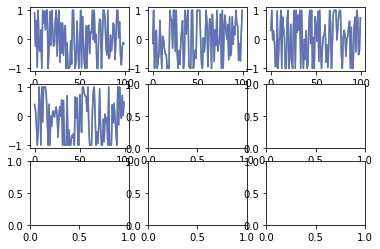

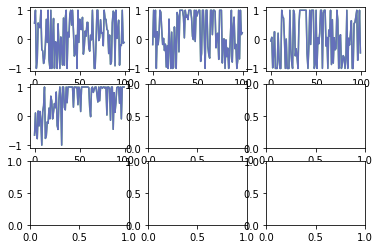

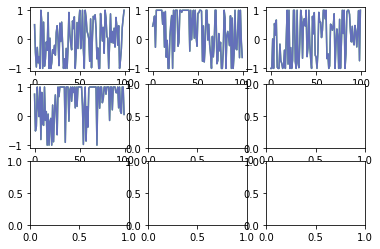

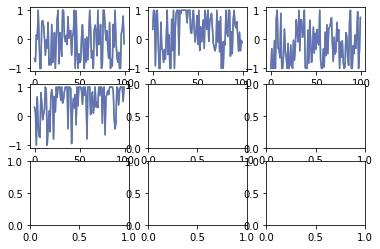

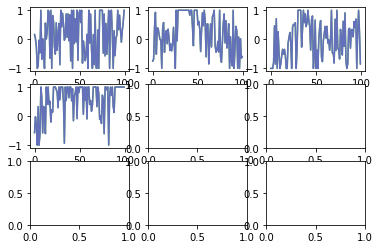

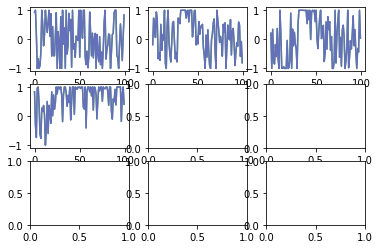

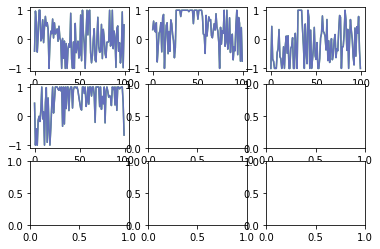

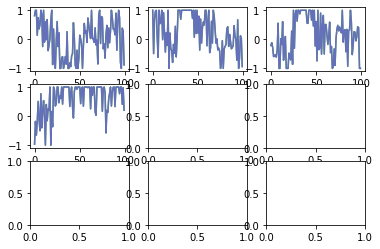

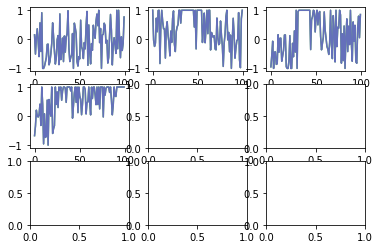

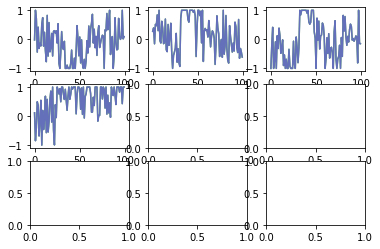

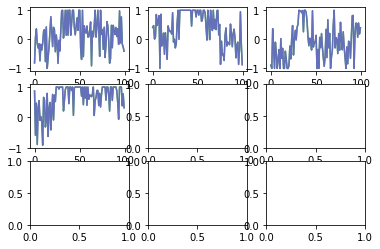

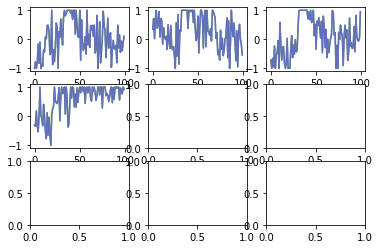

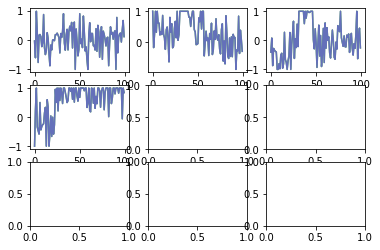

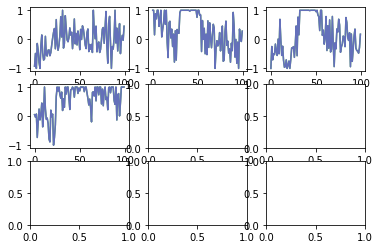

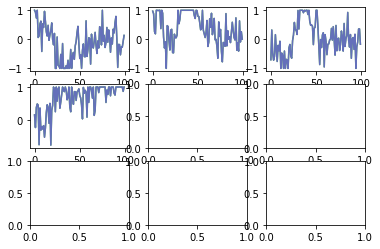

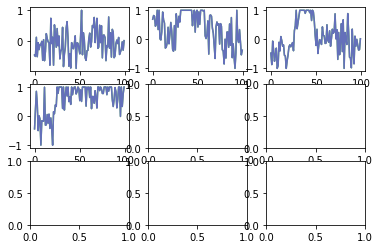

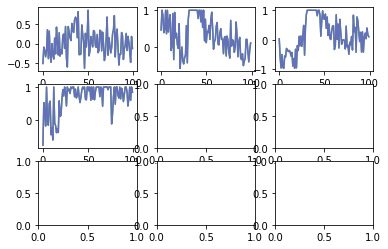

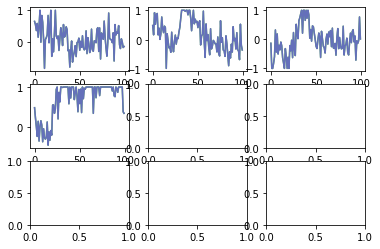

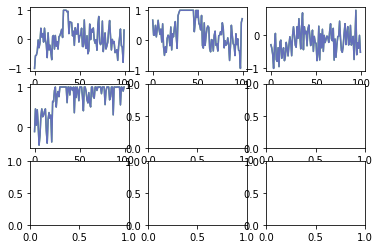

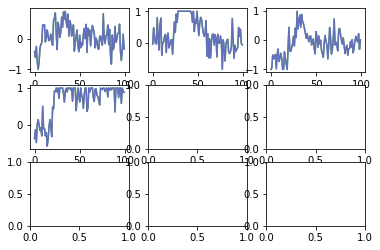

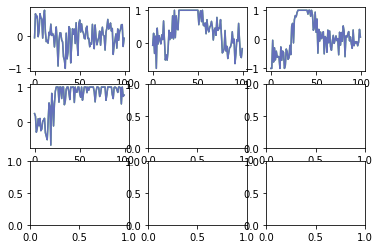

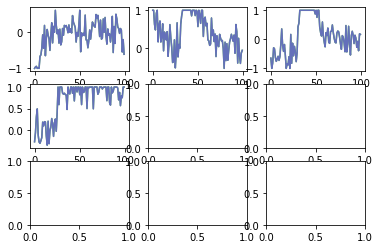

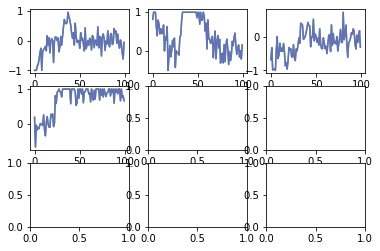

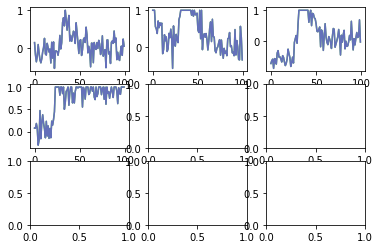

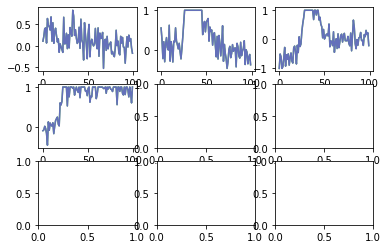

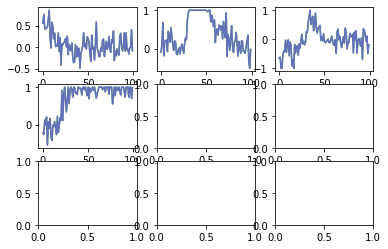

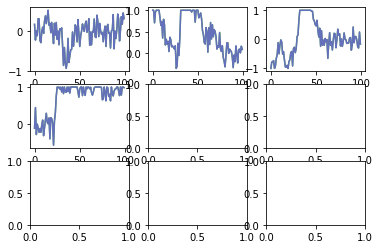

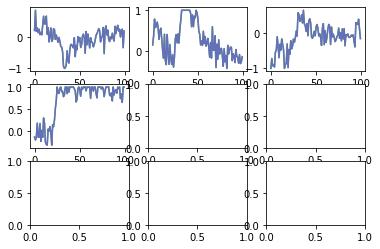

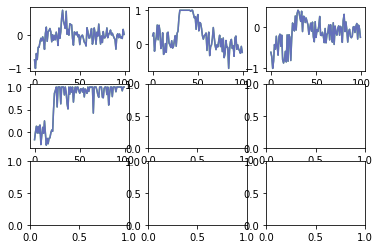

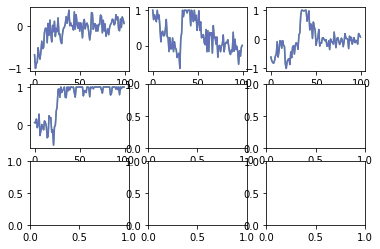

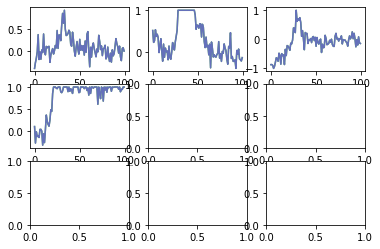

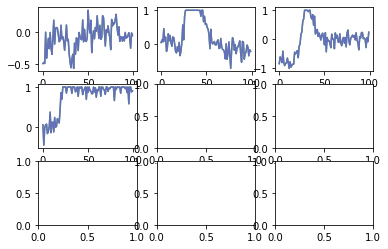

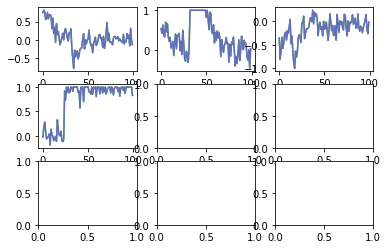

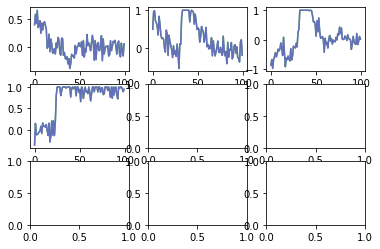

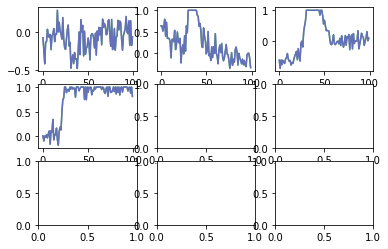

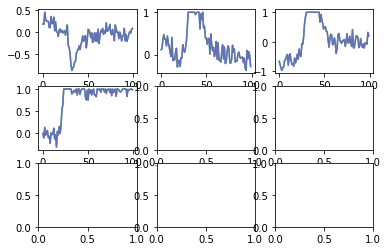

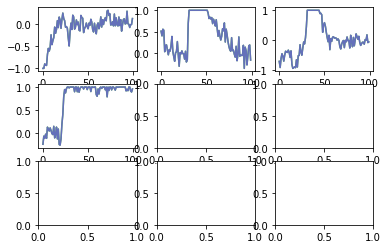

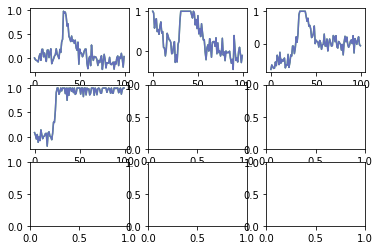

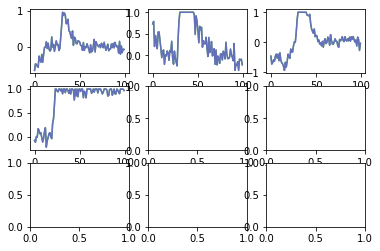

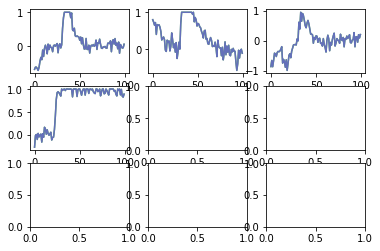

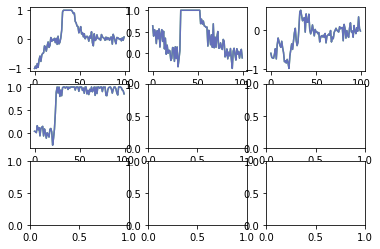

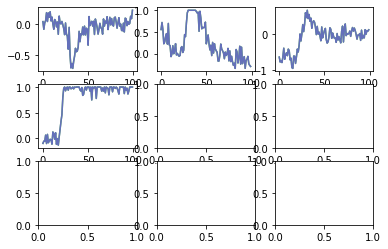

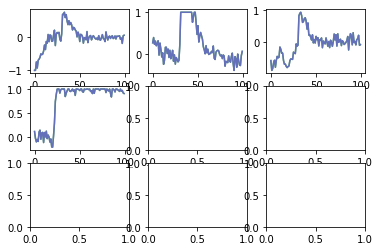

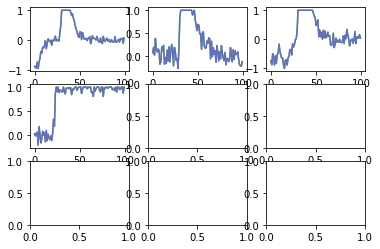

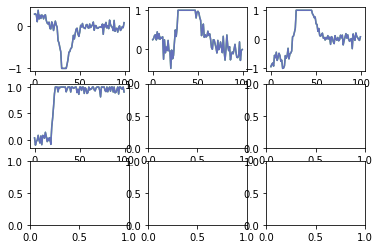

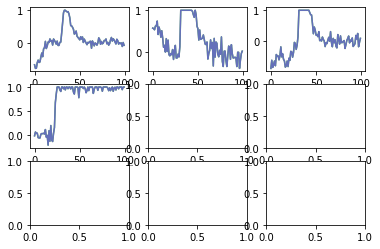

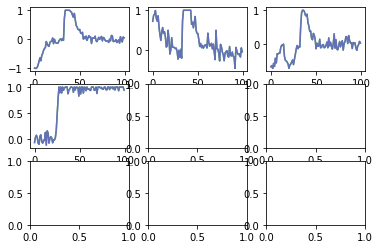

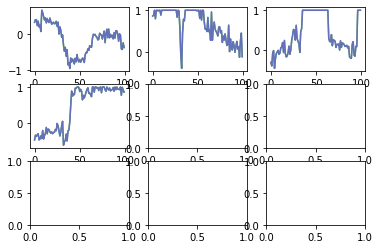

In [20]:
for i in range(1000):
    benchmark_policy(
    policy=learner.policy,
    path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/bc ppo pickplace 2000 non observable/',
    logname='non observable',
    eval_epochs=100,
    val_env=dnosr,
    stepid=i,
    best_reward=0,
    save_model=True,
    new_epoch=new_epoch,
    extractor=DummyExtractor())
    bc_trainer_nosr.train(n_epochs=1)

In [ ]:
torch.save(learner.policy.state_dict(), '/tmp/nosr_statedict')

In [ ]:
learner.policy.load_state_dict(torch.load('/tmp/nosr_statedict'))

In [ ]:
learner.policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo bc pickplace 2000 non observable/non observable/best_modeltensor(0.9100)'))

In [ ]:
benchmark_policy(
    policy=learner.policy,
    path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/h/',
    logname='b',
    eval_epochs=100,
    val_env=dnosr,
    stepid=0,
    best_reward=0,
    save_model=True,
    new_epoch=new_epoch,
    extractor=DummyExtractor())

In [ ]:
for i in range(1000):
    benchmark_policy(
        policy=learner.policy,
        path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/ppo continue nosr 2000',
        logname='ppo nosr 2000',
        eval_epochs=100,
        val_env=dnosr,
        stepid=10*i,
        best_reward=0,
        save_model=True,
        new_epoch=new_epoch,
        extractor=DummyExtractor())
    learner.learn(total_timesteps=1000)

In [ ]:
bc_trainer.train(n_epochs=100, log_interval=1000000)

In [ ]:
for i in range(1000):
    benchmark_policy(
    policy=bc_trainer.policy,
    path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation ppo pickplace 10/',
    logname='BC trainer pickplace 10',
    eval_epochs=100,
    val_env=dv1,
    stepid=i,
    best_reward=0,
    save_model=True,
    new_epoch=new_epoch,
    extractor=DummyExtractor())
    bc_trainer.train(n_epochs=100, log_interval=1000000)


In [ ]:
best_policy = ActorCriticPolicy(observation_space=dv1.observation_space, action_space=dv1.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [dict(pi=[512, 512, 512], vf=[512, 512, 512])])
best_policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation bc pickplace 10/BC trainer pickplace 10/best_modeltensor(0.0900)'))

In [ ]:
observation_space=dv1.observation_space, action_space=dv1.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [dict(pi=[512, 512, 512], qf=[512, 512, 512])]

In [ ]:
from stable_baselines3.sac.policies import SACPolicy

In [ ]:
policy = SACPolicy(observation_space=dv1.observation_space, action_space=dv1.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [512, 512, 512])

In [ ]:
sac_trainer = SAC(policy='MlpPolicy', env=dv1, learning_rate=5e-5)

In [ ]:
obsv, _ = policy.obs_to_tensor(dv1.reset())

In [ ]:
policy.actor

In [ ]:
acp = ActorCriticPolicy(observation_space=dv1.observation_space, action_space=dv1.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [512, 512, 512])

In [ ]:
policy.load_state_dict(acp.state_dict())

In [ ]:
policy.actor.load_state_dict(acp.state_dict())

In [ ]:
acp

In [ ]:
policy.actor

In [ ]:
benchmark_policy(
    policy=sac_trainer.policy,
    path= '/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation bc pickplace 10/reload_test/',
    logname='BC trainer pickplace 10 best',
    eval_epochs=500,
    val_env=dv1,
    stepid=i,
    best_reward=0,
    save_model=True,
    new_epoch=new_epoch,
    extractor=DummyExtractor())


In [ ]:
torch.save(bc_trainer.policy.state_dict, '/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation bc pickplace 10/BC trainer pickplace 10/last')

In [ ]:
best_policy = ActorCriticPolicy(observation_space=dv1.observation_space, action_space=dv1.action_space, lr_schedule=lambda _: torch.finfo(torch.float32).max, net_arch = [dict(pi=[512, 512, 512], vf=[512, 512, 512])])
best_policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation bc pickplace 10/BC trainer pickplace 10/last')())

In [ ]:
asd = SAC(policy='MlpPolicy', env=dv1, learning_rate=5e-5)

In [ ]:
asd.policy

In [ ]:
ppo_trainer = PPO(policy='MlpPolicy', env=dv1, learning_rate=5e-5, policy_kwargs=dict(net_arch = [dict(pi=[512, 512, 512], vf=[512, 512, 512])]))

In [ ]:
ppo_trainer.policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/stableBaselines/imitation bc pickplace 10/BC trainer pickplace 10/last')())

In [ ]:
bc_trainer.train(n_epochs=10, log_interval=1000)

In [ ]:
val_env.reset_envs_sampled()
train_policy(
    trainer=bc_trainer, 
    learn_fct = bc_trainer.train, 
    val_env=val_env, 
    logname='BC_train_medium', 
    path='/home/hendrik/Documents/master_project/LokalData/stableBaselines/', 
    n_epochs=10000, 
    n_steps=100,
    eval_epochs=200)

In [ ]:
train_env.reset_envs_sampled()

In [ ]:
rein_trainer = PPO("MlpPolicy", train_env, verbose=1, )

In [ ]:
rein_trainer.policy = bc_trainer.policy

In [ ]:
bc_trainer.policy.load_state_dict(torch.load('/home/hendrik/Documents/master_project/LokalData/test/bc_hard_100tensor(0.5380)'))
rein_model.policy = bc_trainer.policy

In [ ]:
rein_trainer = SAC("MlpPolicy", train_env, verbose=0)
rein_trainer.policy = bc_trainer.policy


In [ ]:
import gym
from stable_baselines3 import PPO
import torch
import numpy as np
from imitation.algorithms import bc
from utilsMW.dataLoaderMW import TorchDatasetMWToy

import numpy as np

from stable_baselines3.common.policies import ActorCriticPolicy

from searchTest.utils import MyEnv, ToyExpertModel, sample_expert_transitions, benchmark_policy
path_train = '/home/hendrik/Documents/master_project/LokalData/metaworld/large/train/'
path_validate = '/home/hendrik/Documents/master_project/LokalData/metaworld/large/val/'
train_data = TorchDatasetMWToy(path=path_train, device='cpu')
val_data = TorchDatasetMWToy(path=path_validate, device='cpu')
print(train_data.data.shape)
print(train_data.label.shape)
MyEnv.set_train_data(train_data, tol_neg=-0.8, tol_pos=0.8, window=31)
ToyExpertModel.set_datasets(train_data=train_data, val_data=val_data)
train_env = MyEnv()
val_env = MyEnv(data=val_data)
my_expert = ToyExpertModel(train_data=train_data, env=train_env)

In [ ]:
class LearnWrapper():
    def __init__(self, trainer):
        self.trainer = trainer
    
    def train(self, n_epochs):
        self.trainer.learn(total_timesteps=n_epochs, log_interval=140000)
            

In [ ]:
learn_wrapper = LearnWrapper(my_expert)
train_env.reset_envs_sampled()
benchmark_policy(trainer=my_expert, learn_fct = learn_wrapper.train, val_env=val_env, logname='SAC trainer test', path='/home/hendrik/Documents/master_project/LokalData/stableBaselines/', n_epochs=100, n_steps=10, eval_epochs=100)


In [ ]:
envp = gym.make("Pendulum-v1")

In [ ]:
def get_num_bits(interger):
    return int(torch.ceil(torch.log2(torch.tensor(interger))))

In [ ]:
get_num_bits(200)

In [ ]:
import gym
import numpy as np

from stable_baselines3 import SAC

env = envp

model = SAC("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000, log_interval=4)
model.save("sac_pendulum")

del model # remove to demonstrate saving and loading

model = SAC.load("sac_pendulum")

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()